In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
import plotly.graph_objs as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import requests
import plotly.express as px
from datetime import timedelta

In [2]:
# Konstante
SENSEBOX_ID="6793f4e4c326f20007c34dd2"
API_URL_FORMAT_BOX="https://api.opensensemap.org/boxes/{sensebox_id}?format={response_format}"
API_URL_FORMAT_SENSOR="https://api.opensensemap.org/boxes/{sensebox_id}/data/{sensor_id}?from-date={fromDate}&to-date={toDate}&download=true&format=json"

# Ein dict erzeugen mit {sensor name : sensor id} und ausgeben lassen
def get_sensor_names_ids():
    url = API_URL_FORMAT_BOX.format(sensebox_id=SENSEBOX_ID,response_format="json")
    status_code = requests.get(url).status_code
    assert status_code , f"Failed fetching data from api {status_code}"
    
    sensors = requests.get(url).json().get("sensors")
    sensor_name_id = {}
    for sensor in sensors:
        name = sensor.get('title').replace(" ","").replace(".","_").replace("-","_")
        _id = sensor.get('_id')
        sensor_name_id.update({name : _id})
    return sensor_name_id

### So kann man die namen und ids als eine Liste haben

In [3]:
get_sensor_names_ids().keys(), get_sensor_names_ids().values()

(dict_keys(['Temperatur', 'rel_Luftfeuchte', 'Beleuchtungsstärke', 'UV_Intensität', 'PM1', 'PM2_5', 'PM4', 'PM10']),
 dict_values(['6793f4e4c326f20007c34dd3', '6793f4e4c326f20007c34dd4', '6793f4e4c326f20007c34dd5', '6793f4e4c326f20007c34dd6', '6793f4e4c326f20007c34dd7', '6793f4e4c326f20007c34dd8', '6793f4e4c326f20007c34dd9', '6793f4e4c326f20007c34dda']))

### Dict Ausgabe von der Funktion

In [4]:
get_sensor_names_ids()

{'Temperatur': '6793f4e4c326f20007c34dd3',
 'rel_Luftfeuchte': '6793f4e4c326f20007c34dd4',
 'Beleuchtungsstärke': '6793f4e4c326f20007c34dd5',
 'UV_Intensität': '6793f4e4c326f20007c34dd6',
 'PM1': '6793f4e4c326f20007c34dd7',
 'PM2_5': '6793f4e4c326f20007c34dd8',
 'PM4': '6793f4e4c326f20007c34dd9',
 'PM10': '6793f4e4c326f20007c34dda'}

### So kann man auf die einzelne Namen zugreifen

In [5]:
sensor_id = get_sensor_names_ids()["Temperatur"]
sensor_id

'6793f4e4c326f20007c34dd3'

### create_dataframe function mit inputs sensor_id und from- und toDate die einen default Wert haben

In [6]:
def create_dataframe(days_back=100):
    sensor_ids = get_sensor_names_ids()
    end_date = datetime.utcnow()
    start_date = end_date - timedelta(days=days_back)

    df_all = pd.DataFrame()

    for name, sensor_id in sensor_ids.items():
        url = API_URL_FORMAT_SENSOR.format(
            sensebox_id=SENSEBOX_ID,
            sensor_id=sensor_id,
            fromDate=start_date.isoformat() + "Z",
            toDate=end_date.isoformat() + "Z"
        )
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Fehler beim Abrufen von {name}: {response.status_code}")
            continue

        data = response.json()
        if not data:
            print(f"Keine Daten für {name}")
            continue

        df_sensor = pd.DataFrame(data)
        df_sensor["createdAt"] = pd.to_datetime(df_sensor["createdAt"])
        df_sensor = df_sensor[["createdAt", "value"]].rename(columns={"value": name})
        df_sensor.set_index("createdAt", inplace=True)

        df_all = df_all.join(df_sensor, how="outer")

    return df_all.sort_index()

In [7]:
#data = create_dataframe(sensor_id=get_sensor_names_ids()["Temperatur"])

In [8]:
#data

In [9]:
df = create_dataframe()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2025-06-19 19:08:36.371000+00:00 to 2025-06-26 22:26:19.018000+00:00
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Temperatur          10000 non-null  object
 1   rel_Luftfeuchte     10000 non-null  object
 2   Beleuchtungsstärke  10000 non-null  object
 3   UV_Intensität       10000 non-null  object
 4   PM1                 10000 non-null  object
 5   PM2_5               10000 non-null  object
 6   PM4                 10000 non-null  object
 7   PM10                10000 non-null  object
dtypes: object(8)
memory usage: 703.1+ KB


In [11]:
df

,Temperatur,rel_Luftfeuchte,Beleuchtungsstärke,UV_Intensität,PM1,PM2_5,PM4,PM10
createdAt,,,,,,,,
2025-06-19 19:08:36.371000+00:00,27.68,94.70,7.00,0.00,227.03,240.08,240.08,240.08
2025-06-19 19:09:36.371000+00:00,27.68,94.59,7.00,0.00,229.90,243.11,243.11,243.11
2025-06-19 19:10:33.696000+00:00,27.63,94.70,7.00,0.00,232.99,246.38,246.38,246.38
2025-06-19 19:11:34.036000+00:00,27.69,94.79,7.00,0.00,244.49,258.53,258.53,258.53
2025-06-19 19:12:37.268000+00:00,27.62,94.59,6.00,0.00,226.22,239.22,239.22,239.22
...,...,...,...,...,...,...,...,...
2025-06-26 22:22:17.987000+00:00,27.81,93.66,0.00,0.00,327.51,346.33,346.33,346.33
2025-06-26 22:23:18.372000+00:00,27.88,93.66,0.00,0.00,337.26,356.64,356.64,356.64
2025-06-26 22:24:18.546000+00:00,27.80,93.56,0.00,0.00,329.22,348.13,348.13,348.13


## Temperaturvorhersage für 48 Stunden:

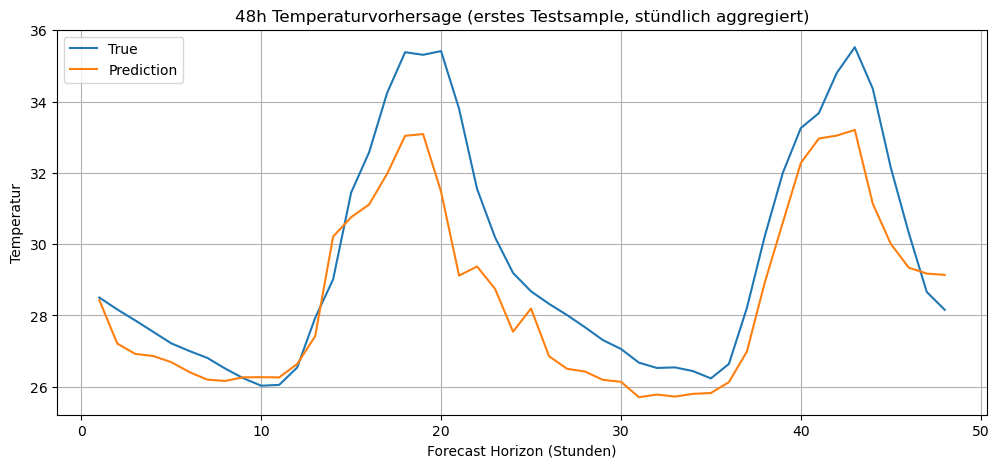

In [12]:

# Sensebox speichert created_at als Index. Wir brauchen diesen aber als Spalte um die Zeitreihe zu verwenden
df = df.reset_index()
df['createdAt'] = pd.to_datetime(df['createdAt'])

# Ebenfalls speichert die Sensebox alle Variablen als Objekte. So können wir keine Aggregationen oder ähnliches anwenden. Deswegen
for col in df.columns:
    if col != 'createdAt': #created_at ist bereits oben als Datetime gelistet
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Wir setzen created_at jetzt gewollt als Index, damit wir die Daten stündlich resamplen können
df.set_index('createdAt', inplace=True)

# Stündliches resampling
df_hourly = df.resample('1h').mean().dropna().reset_index()

# Zeitmerkmale für zusätzliche erzeugen
df_hourly['hour'] = df_hourly['createdAt'].dt.hour
df_hourly['dayofweek'] = df_hourly['createdAt'].dt.dayofweek

# 48 Zielspalten erzeugen, damit wir für 48h die Temperatur vorhersagen können
for i in range(1, 49):
    df_hourly[f'Temperatur_t+{i}'] = df_hourly['Temperatur'].shift(-i)

# Zeilen bei denen einer dieser Zielwerte fehlt müssen gedropt werden, sonst können wir keine Vorhersagen machen
df_multi = df_hourly.dropna(subset=[f'Temperatur_t+{i}' for i in range(1, 49)]).copy()

# Feature definieren
feature_cols = ['Temperatur', 'rel_Luftfeuchte', 'Beleuchtungsstärke', 'UV_Intensität', 'hour', 'dayofweek', 'PM1', 'PM2_5', 'PM4', 'PM10']

#Aufteilung in Feature und Label
X_multi = df_multi[feature_cols]
y_multi = df_multi[[f'Temperatur_t+{i}' for i in range(1, 49)]]

# Split in Trainings und Testdaten. 80% Trainingsdaten und 20% Testdaten
split_index = int(len(df_multi) * 0.8)
X_train_multi, X_test_multi = X_multi[:split_index], X_multi[split_index:]
y_train_multi, y_test_multi = y_multi[:split_index], y_multi[split_index:]


# Wir trainieren unser Modell für die 48h, es werden intern 48 unabhängige Forest trainiert, aber mit den gleichen Feature

multi_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
multi_model.fit(X_train_multi, y_train_multi)

# Vorhersage machen
y_pred_multi = multi_model.predict(X_test_multi)

# Visualisierung der vorhergesagten Daten mit den tatsächlichen Daten

plt.figure(figsize=(12, 5))
plt.plot(range(1, 49), y_test_multi.iloc[0], label='True')
plt.plot(range(1, 49), y_pred_multi[0], label='Prediction')
plt.xlabel("Forecast Horizon (Stunden)")
plt.ylabel("Temperatur")
plt.title("48h Temperaturvorhersage (erstes Testsample, stündlich aggregiert)")
plt.legend()
plt.grid()
plt.show()


#### Kennzahlen unseres Models ausgeben:

In [13]:
# Gesamte Metriken berechnen (alle 48 Stunden auf einmal)
mae_total = mean_absolute_error(y_test_multi, y_pred_multi)
rmse_total = mean_squared_error(y_test_multi, y_pred_multi, squared=False)
r2_total = r2_score(y_test_multi, y_pred_multi)

print(f"Gesamte Modellgüte (über alle 48 Forecast-Stunden):")
print(f"MAE:  {mae_total:.3f}")
print(f"RMSE: {rmse_total:.3f}")
print(f"R²:   {r2_total:.3f}")


Gesamte Modellgüte (über alle 48 Forecast-Stunden):
MAE:  1.255
RMSE: 1.687
R²:   0.654


MAE, RMSE sind ok. R² Wert leider sehr hoch, das liegt aber wahrscheinlich an der sehr kleinen Datenmenge

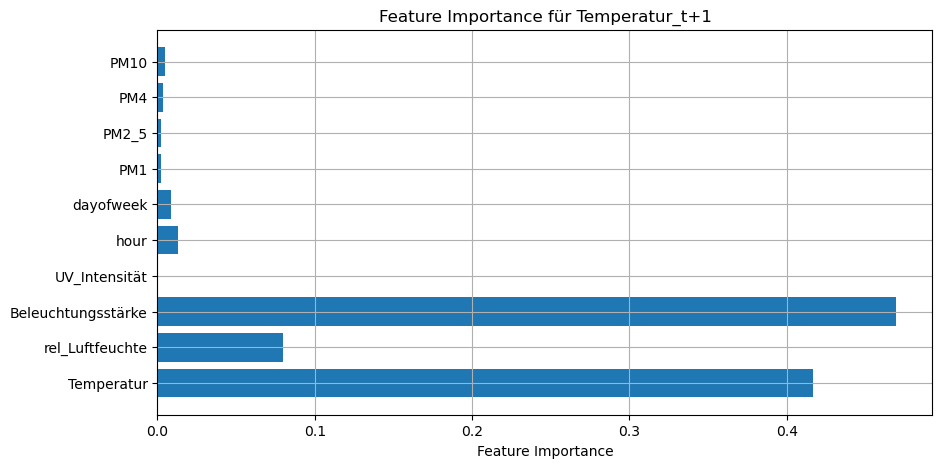

In [14]:
# Feature Importances für die erste Stunde

importances = multi_model.estimators_[0].feature_importances_
features = X_multi.columns

# Visualisierung der Feautureimportance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance für Temperatur_t+1")
plt.grid()
plt.show()


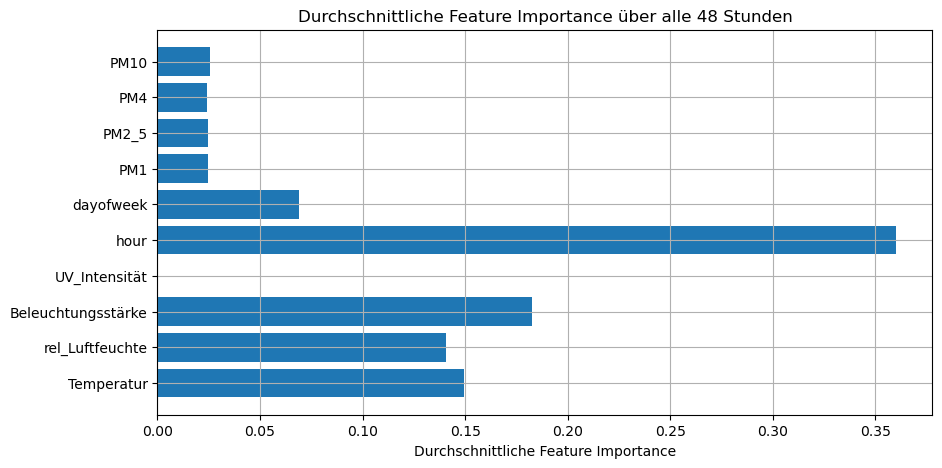

In [15]:
# Mittlere Feature Importance über alle 48 Modelle
importances_avg = np.mean([est.feature_importances_ for est in multi_model.estimators_], axis=0)

#Visualisierung der Featureimportance
plt.figure(figsize=(10, 5))
plt.barh(features, importances_avg)
plt.xlabel("Durchschnittliche Feature Importance")
plt.title("Durchschnittliche Feature Importance über alle 48 Stunden")
plt.grid()
plt.show()


In [16]:

# 'createdAt' vom ersten Testsample aus df_multi nehmen
forecast_start_time = df_multi.iloc[split_index]['createdAt'] + timedelta(days=3) #Datum der Vorhersage anpassen

# Liste der 48 Stunden-Zeitpunkte erzeugen
forecast_dates = [forecast_start_time + timedelta(hours=i) for i in range(1, 49)]

# Die zugehörigen Vorhersagewerte für das erste Testsample
forecast_values = y_pred_multi[0]

In [17]:
# senseBox ID
SENSEBOX_ID = "6793f4e4c326f20007c34dd2"

# Verfügbare Sensoren und ihre Titel
SENSOR_TITLES = {
    'temperature': 'Temperatur',
    'humidity': 'rel. Luftfeuchte',
    'illuminance': 'Beleuchtungsstärke',
    'pm1': 'PM1',
    'pm25': 'PM2.5',
    'pm4': 'PM4',
    'pm10': 'PM10'
}

In [18]:
# Funktion: Sensor-IDs abrufen
def get_sensor_ids(box_id):
    url = f"https://api.opensensemap.org/boxes/{box_id}"
    response = requests.get(url)
    data = response.json()
    sensor_ids = {}
    for sensor in data.get('sensors', []):
        title = sensor.get('title', '').lower()
        for key, expected in SENSOR_TITLES.items():
            if title == expected.lower():
                sensor_ids[key] = sensor.get('_id')
    return sensor_ids

In [19]:
# Funktion: Messdaten abrufen (letzte 7 Tage)
def get_sensor_data(sensor_id):
    from datetime import datetime, timedelta

    seven_days_ago = (datetime.utcnow() - timedelta(days=7)).isoformat() + "Z"
    url = f"https://api.opensensemap.org/boxes/{SENSEBOX_ID}/data/{sensor_id}?format=json&from-date={seven_days_ago}"
    
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data)
    df['createdAt'] = pd.to_datetime(df['createdAt'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    return df

In [20]:
# Sensor-IDs initial laden
sensor_ids = get_sensor_ids(SENSEBOX_ID)

# Dash-App initialisieren
app = dash.Dash(__name__)
app.title = "senseBox Dashboard"

In [21]:
# Layout: zwei Grafiken (aktuelle Daten + leere Prognose) + Dropdown rechts
app.layout = html.Div(
    style={'display': 'flex', 'flexDirection': 'row', 'height': '100vh'},
    children=[
        # Linke Seite: zwei Grafiken übereinander
        html.Div(
    style={'flex': 1, 'display': 'flex', 'flexDirection': 'column'},
    children=[
        # Grafik für aktuelle Sensordaten
        dcc.Graph(id='main-graph', style={'flex': 1}),

        # Grafik für zukünftige (ML-)Daten
        dcc.Graph(
            id='forecast-graph',
            figure={
                'data': [
                    go.Scatter(
                        x=forecast_dates,
                        y=forecast_values,
                        mode='lines+markers',
                        name='Vorhersage Temperatur'
                    )
                ],
                'layout': {
            'title': {
                'text': '48h Temperaturvorhersage',
                'x': 0.5,
                'xanchor': 'center'
            },
            'xaxis': {'title': 'Zeit'},
            'yaxis': {'title': 'Temperatur [°C]'},
            'margin': {'l': 100, 'r': 20, 't': 40, 'b': 40}
        }
    },
            style={'flex': 1}
        )
    ]
),
        # Rechte Seite: Dropdown-Menu zur Sensorauswahl
        html.Div(
            style={'width': '220px', 'padding': '10px'},
            children=[
                html.Label("Sensor auswählen:"),
                dcc.Dropdown(
                    id='sensor-dropdown',
                    options=[{'label': title, 'value': key} for key, title in SENSOR_TITLES.items()],
                    value='temperature',
                    clearable=False,
                    style={'font-size': '16px'}
                )
            ]
        ),
        # Interval-Komponente bleibt unverändert
        dcc.Interval(
            id='interval-component',
            interval=5*60*1000,  # alle 5 Minuten
            n_intervals=0
        )
    ]
)

In [22]:
#  Grafik basierend auf Auswahl + Intervall aktualisieren
@app.callback(
    Output('main-graph', 'figure'),
    Input('sensor-dropdown', 'value'),
    Input('interval-component', 'n_intervals')
)

def update_graph(selected_sensor, n):
    sensor_id = sensor_ids.get(selected_sensor)
    if sensor_id:
        df = get_sensor_data(sensor_id)

        # Ermitteln des zuletzt gemessenen Werts
        latest_value = df['value'].iloc[-1] if not df.empty else None
        latest_time = df['createdAt'].iloc[-1] if not df.empty else None

        # Grafik erstellen (Linie oder Scatter)
        if selected_sensor in ['pm1', 'pm25', 'pm4', 'pm10', 'illuminance']:
            fig = px.scatter(df, x='createdAt', y='value', title=SENSOR_TITLES[selected_sensor])
        else:
            fig = px.line(df, x='createdAt', y='value', title=SENSOR_TITLES[selected_sensor])

        # Layout-Anpassungen
        fig.update_layout(
            xaxis_title='Zeit',
            yaxis_title=SENSOR_TITLES[selected_sensor],
            margin={'l': 100, 'r': 20, 't': 40, 'b': 40},
            title={'x': 0.5, 'xanchor': 'center'}
        )
        # Tick-Größen und Range-Selector Buttons
        fig.update_yaxes(
            title_font_size=18,
            tickfont_size=16,
            automargin=True
        )
        fig.update_xaxes(
            tickfont_size=14,
            rangeselector=dict(
                buttons=[
                    #dict(step='all', label='All'),
                    dict(count=12, label='12h', step='hour', stepmode='backward'),
                    dict(count=1, label='1d', step='day', stepmode='backward'),
                    dict(count=7, label='7d', step='day', stepmode='backward')
                ]
            ),
            rangeslider=dict(visible=False)
        )

        # Annotation: zuletzt gemessener Wert oben rechts
        if latest_value is not None:
            text = f"Aktuell: {latest_value:.2f}"
            fig.add_annotation(
                xref='paper', yref='paper',
                x=1, y=1,
                xanchor='right', yanchor='top',
                text=text,
                showarrow=False,
                font=dict(size=14)
            )
    else:
        # Fehlermeldung, falls Sensor nicht verfügbar
        fig = px.scatter(title=f"{SENSOR_TITLES.get(selected_sensor, 'Sensor')} nicht verfügbar")
        fig.update_layout(margin={'l': 100, 'r': 20, 't': 40, 'b': 40})

    return fig

In [23]:
# Server starten
if __name__ == '__main__':
    app.run(debug=True)